# Query to reference mapping

In [1]:
from matplotlib import pyplot as plt
import multigrate as mtg
import scanpy as sc
import pandas as pd

Global seed set to 0


In [2]:
%load_ext autoreload
%autoreload 2

# Load preprocessed data

We recommend using raw counts for scRNA-seq and TF-IDF normalized expression for ATAC-seq. You can also input binarized counts for ATAC, but normalized expression seems to integrate a bit better.

In [3]:
rna = sc.read('/home/icb/anastasia.litinetskaya/data/stephenson-2021/stephenson2021_rna_hvg.h5ad')
adt = sc.read('/home/icb/anastasia.litinetskaya/data/stephenson-2021/stephenson2021_adt.h5ad')

In [4]:
rna

AnnData object with n_obs × n_vars = 571327 × 4000
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'split0', 'split1', 'split2', 'split3', 'split4'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [5]:
adt

AnnData object with n_obs × n_vars = 571327 × 192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'split0', 'split1', 'split2', 'split3', 'split4'
    var: 'feature_types'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'count'

In [6]:
idx = adt.obs['patient_id'].sort_values().index

In [7]:
adt = adt[idx].copy()
rna = rna[idx].copy()

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


# Prep the input AnnData object

First, we need to organize anndatas correspoding to different datasets and modalities into 1 anndata object. Here in this example we have 1 CITE-seq dataset, hence we input 2 anndata objects, 1 for RNA modality, 1 for ADT modality, and specify that they are paired (```groups``` argument).

Notes:
- paired datasets have to have the same .obs_names, i.e. index
- if there are batch effects in one dataset, please split the data into batches beforehand, becaues the model treats each input anndata object as 1 batch

If we had more unpaired data here, e.g. 1 paired RNA-ATAC dataset (```rna1```, ```atac1```) and 2 other RNA datasets (```rna2```, ```rna3```), we would have to first subset the RNA modality to the set of common genes (and then possibly to highly variable genes). Then we would need to specify
```adata = [[rna1, rna2, rna3], [atac]]``` and ```groups = [[0, 1, 2], [0]]```.

In [8]:
adata = mtg.data.organize_multiome_anndatas(
    adatas = [[rna], [adt]],     # a list of anndata objects per modality, RNA-seq always goes first
    groups = [[0], [0]],         # specify that paired
    layers = [['count'], [None]] # if need to use data from .layers, if None use .X
)
adata

AnnData object with n_obs × n_vars = 571327 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'split0', 'split1', 'split2', 'split3', 'split4', 'group'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'count'

Sanity check: in case of multiple datasets `len(adata)` should be equal `len(rna1) + len(rna2) + len(rna3)`.

Split adata into ref and query (i.e. train and test)

In [9]:
query = adata[adata.obs['split'] == 'test']
adata = adata[adata.obs['split'] == 'train']

From now on, we work with one concatenated anndata object ```adata```.

If using raw counts for scRNA, we need to use NB loss (or ZINB), thus need to calculate `size_factors` first. If using normalized counts and MSE for scRNA, `rna_indices_end` does not need to be specified.

In [10]:
mtg.model.MultiVAE_MIL.setup_anndata(
    adata,
    rna_indices_end=4000,  # how many features in rna modality
    categorical_covariate_keys=['Sex', 'patient_id', 'Status_on_day_collection_summary'],
    continuous_covariate_keys=['Age'],
    ordinal_regression_order={'Status_on_day_collection_summary': ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]}
)

Trying to set attribute `.obs` of view, copying.


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 530416 cells, 4192 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 3 extra categorical covariates   
         and 2 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


# Initialize the model

Define the model here. If using raw counts for RNA-seq, use NB loss (`'nb'`), if normalized counts, use MSE (`'mse'`) for RNA, ADT and ATAC. If using binarized counts for ATAC-seq, use BCE (`'bce'`).

In [11]:
mil = mtg.model.MultiVAE_MIL(
    adata, 
    modality_lengths=[4000, 192], # how many features per modality
    losses=['nb', 'mse'],         # what losses to use for each modality
    loss_coefs={'kl': 1e-4,
               'integ': 0}, # depending on the datasets, might need to fine-tune loss coeficients, done here
    ordinal_regression=['Status_on_day_collection_summary'],
    patient_label='patient_id',
    attn_dim=15,
    z_dim=15,
    cond_dim=10,
    dropout=0.2,
    patient_batch_size=128,
    n_layers_encoders=[2, 2],
    n_layers_regressor=2,
    regression_loss_coef=0.5,
)

The order for Status_on_day_collection_summary ordinal classes is: Index(['Healthy', 'Asymptomatic', 'Mild', 'Moderate', 'Severe', 'Critical'], dtype='object'). If you need to change the order, please rerun setup_anndata and specify the correct order with "ordinal_regression_order" parameter.


/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


# Train the model

Can specify the number of epochs by setting `max_epochs` parameter, default is 500.

In [12]:
mil.train(max_epochs=200, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Epoch 1/200:   0%|          | 1/200 [00:24<1:22:05, 24.75s/it, loss=710, v_num=1]

Metric elbo_validation improved. New best score: 669.664


Epoch 2/200:   1%|          | 2/200 [00:51<1:25:48, 26.00s/it, loss=659, v_num=1]

Metric elbo_validation improved by 41.102 >= min_delta = 0.0. New best score: 628.562


Epoch 3/200:   2%|▏         | 3/200 [01:18<1:26:26, 26.33s/it, loss=613, v_num=1]

Metric elbo_validation improved by 35.312 >= min_delta = 0.0. New best score: 593.251


Epoch 4/200:   2%|▏         | 4/200 [01:45<1:26:19, 26.43s/it, loss=588, v_num=1]

Metric elbo_validation improved by 32.589 >= min_delta = 0.0. New best score: 560.661


Epoch 5/200:   2%|▎         | 5/200 [02:11<1:25:34, 26.33s/it, loss=542, v_num=1]

Metric elbo_validation improved by 34.318 >= min_delta = 0.0. New best score: 526.343


Epoch 6/200:   3%|▎         | 6/200 [02:38<1:26:07, 26.64s/it, loss=527, v_num=1]

Metric elbo_validation improved by 15.559 >= min_delta = 0.0. New best score: 510.784


Epoch 7/200:   4%|▎         | 7/200 [03:05<1:25:46, 26.67s/it, loss=523, v_num=1]

Metric elbo_validation improved by 10.725 >= min_delta = 0.0. New best score: 500.060


Epoch 8/200:   4%|▍         | 8/200 [03:31<1:25:11, 26.62s/it, loss=524, v_num=1]

Metric elbo_validation improved by 6.889 >= min_delta = 0.0. New best score: 493.171


Epoch 9/200:   4%|▍         | 9/200 [03:58<1:24:38, 26.59s/it, loss=508, v_num=1]

Metric elbo_validation improved by 4.314 >= min_delta = 0.0. New best score: 488.857


Epoch 10/200:   5%|▌         | 10/200 [04:25<1:24:31, 26.69s/it, loss=523, v_num=1]

Metric elbo_validation improved by 3.928 >= min_delta = 0.0. New best score: 484.928


Epoch 11/200:   6%|▌         | 11/200 [04:52<1:24:14, 26.75s/it, loss=506, v_num=1]

Metric elbo_validation improved by 3.273 >= min_delta = 0.0. New best score: 481.655


Epoch 12/200:   6%|▌         | 12/200 [05:19<1:24:37, 27.01s/it, loss=505, v_num=1]

Metric elbo_validation improved by 3.077 >= min_delta = 0.0. New best score: 478.578


Epoch 13/200:   6%|▋         | 13/200 [05:45<1:23:28, 26.78s/it, loss=495, v_num=1]

Metric elbo_validation improved by 3.309 >= min_delta = 0.0. New best score: 475.269


Epoch 14/200:   7%|▋         | 14/200 [06:11<1:22:16, 26.54s/it, loss=492, v_num=1]

Metric elbo_validation improved by 2.561 >= min_delta = 0.0. New best score: 472.708


Epoch 15/200:   8%|▊         | 15/200 [06:38<1:21:35, 26.46s/it, loss=511, v_num=1]

Metric elbo_validation improved by 2.855 >= min_delta = 0.0. New best score: 469.853


Epoch 16/200:   8%|▊         | 16/200 [07:05<1:21:39, 26.63s/it, loss=501, v_num=1]

Metric elbo_validation improved by 1.893 >= min_delta = 0.0. New best score: 467.960


Epoch 17/200:   8%|▊         | 17/200 [07:31<1:21:15, 26.64s/it, loss=484, v_num=1]

Metric elbo_validation improved by 2.756 >= min_delta = 0.0. New best score: 465.203


Epoch 18/200:   9%|▉         | 18/200 [07:59<1:21:26, 26.85s/it, loss=486, v_num=1]

Metric elbo_validation improved by 1.564 >= min_delta = 0.0. New best score: 463.639


Epoch 19/200:  10%|▉         | 19/200 [08:25<1:20:54, 26.82s/it, loss=474, v_num=1]

Metric elbo_validation improved by 3.210 >= min_delta = 0.0. New best score: 460.429


Epoch 20/200:  10%|█         | 20/200 [08:52<1:20:22, 26.79s/it, loss=476, v_num=1]

Metric elbo_validation improved by 0.782 >= min_delta = 0.0. New best score: 459.647


Epoch 21/200:  10%|█         | 21/200 [09:19<1:19:54, 26.78s/it, loss=468, v_num=1]

Metric elbo_validation improved by 1.234 >= min_delta = 0.0. New best score: 458.413


Epoch 22/200:  11%|█         | 22/200 [09:46<1:20:04, 26.99s/it, loss=480, v_num=1]

Metric elbo_validation improved by 1.147 >= min_delta = 0.0. New best score: 457.266


Epoch 23/200:  12%|█▏        | 23/200 [10:14<1:19:40, 27.01s/it, loss=454, v_num=1]

Metric elbo_validation improved by 1.503 >= min_delta = 0.0. New best score: 455.763


Epoch 24/200:  12%|█▏        | 24/200 [10:40<1:18:55, 26.91s/it, loss=462, v_num=1]

Metric elbo_validation improved by 1.032 >= min_delta = 0.0. New best score: 454.731


Epoch 26/200:  13%|█▎        | 26/200 [11:34<1:17:56, 26.88s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.958 >= min_delta = 0.0. New best score: 452.369


Epoch 27/200:  14%|█▎        | 27/200 [12:01<1:17:42, 26.95s/it, loss=459, v_num=1]

Metric elbo_validation improved by 1.626 >= min_delta = 0.0. New best score: 450.743


Epoch 28/200:  14%|█▍        | 28/200 [12:28<1:16:56, 26.84s/it, loss=484, v_num=1]

Metric elbo_validation improved by 0.443 >= min_delta = 0.0. New best score: 450.300


Epoch 29/200:  14%|█▍        | 29/200 [12:57<1:18:11, 27.44s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.337 >= min_delta = 0.0. New best score: 449.964


Epoch 30/200:  15%|█▌        | 30/200 [13:26<1:19:08, 27.93s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.870 >= min_delta = 0.0. New best score: 449.093


Epoch 31/200:  16%|█▌        | 31/200 [13:54<1:19:00, 28.05s/it, loss=478, v_num=1]

Metric elbo_validation improved by 1.653 >= min_delta = 0.0. New best score: 447.441


Epoch 32/200:  16%|█▌        | 32/200 [14:21<1:17:27, 27.66s/it, loss=494, v_num=1]

Metric elbo_validation improved by 0.300 >= min_delta = 0.0. New best score: 447.140


Epoch 33/200:  16%|█▋        | 33/200 [14:47<1:16:14, 27.39s/it, loss=473, v_num=1]

Metric elbo_validation improved by 0.228 >= min_delta = 0.0. New best score: 446.913


Epoch 34/200:  17%|█▋        | 34/200 [15:16<1:16:34, 27.68s/it, loss=458, v_num=1]

Metric elbo_validation improved by 1.487 >= min_delta = 0.0. New best score: 445.425


Epoch 36/200:  18%|█▊        | 36/200 [16:14<1:17:38, 28.40s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.761 >= min_delta = 0.0. New best score: 444.664


Epoch 37/200:  18%|█▊        | 37/200 [16:42<1:16:47, 28.27s/it, loss=446, v_num=1]

Metric elbo_validation improved by 0.570 >= min_delta = 0.0. New best score: 444.094


Epoch 38/200:  19%|█▉        | 38/200 [17:12<1:17:01, 28.53s/it, loss=454, v_num=1]

Metric elbo_validation improved by 1.284 >= min_delta = 0.0. New best score: 442.810


Epoch 39/200:  20%|█▉        | 39/200 [17:40<1:17:06, 28.73s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.566 >= min_delta = 0.0. New best score: 442.245


Epoch 40/200:  20%|██        | 40/200 [18:10<1:17:07, 28.92s/it, loss=451, v_num=1]

Metric elbo_validation improved by 0.036 >= min_delta = 0.0. New best score: 442.209


Epoch 41/200:  20%|██        | 41/200 [18:39<1:17:06, 29.10s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.671 >= min_delta = 0.0. New best score: 441.537


Epoch 42/200:  21%|██        | 42/200 [19:08<1:16:35, 29.09s/it, loss=474, v_num=1]

Metric elbo_validation improved by 0.044 >= min_delta = 0.0. New best score: 441.493


Epoch 43/200:  22%|██▏       | 43/200 [19:38<1:16:11, 29.12s/it, loss=461, v_num=1]

Metric elbo_validation improved by 0.742 >= min_delta = 0.0. New best score: 440.751


Epoch 44/200:  22%|██▏       | 44/200 [20:07<1:15:42, 29.12s/it, loss=441, v_num=1]

Metric elbo_validation improved by 0.428 >= min_delta = 0.0. New best score: 440.323


Epoch 45/200:  22%|██▎       | 45/200 [20:36<1:14:54, 29.00s/it, loss=443, v_num=1]

Metric elbo_validation improved by 0.243 >= min_delta = 0.0. New best score: 440.080


Epoch 46/200:  23%|██▎       | 46/200 [21:05<1:14:33, 29.05s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.337 >= min_delta = 0.0. New best score: 439.743


Epoch 47/200:  24%|██▎       | 47/200 [21:34<1:14:05, 29.06s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.535 >= min_delta = 0.0. New best score: 439.208


Epoch 48/200:  24%|██▍       | 48/200 [22:03<1:13:33, 29.04s/it, loss=468, v_num=1]

Metric elbo_validation improved by 0.324 >= min_delta = 0.0. New best score: 438.885


Epoch 49/200:  24%|██▍       | 49/200 [22:32<1:12:57, 28.99s/it, loss=483, v_num=1]

Metric elbo_validation improved by 0.308 >= min_delta = 0.0. New best score: 438.576


Epoch 50/200:  25%|██▌       | 50/200 [23:01<1:12:42, 29.08s/it, loss=445, v_num=1]

Metric elbo_validation improved by 0.464 >= min_delta = 0.0. New best score: 438.113


Epoch 51/200:  26%|██▌       | 51/200 [23:30<1:12:06, 29.04s/it, loss=478, v_num=1]

Metric elbo_validation improved by 0.703 >= min_delta = 0.0. New best score: 437.410


Epoch 53/200:  26%|██▋       | 53/200 [24:28<1:11:18, 29.11s/it, loss=437, v_num=1]

Metric elbo_validation improved by 0.096 >= min_delta = 0.0. New best score: 437.314


Epoch 54/200:  27%|██▋       | 54/200 [24:57<1:10:46, 29.09s/it, loss=443, v_num=1]

Metric elbo_validation improved by 0.534 >= min_delta = 0.0. New best score: 436.780


Epoch 55/200:  28%|██▊       | 55/200 [25:26<1:10:18, 29.09s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.378 >= min_delta = 0.0. New best score: 436.402


Epoch 56/200:  28%|██▊       | 56/200 [25:55<1:09:47, 29.08s/it, loss=448, v_num=1]

Metric elbo_validation improved by 0.233 >= min_delta = 0.0. New best score: 436.169


Epoch 57/200:  28%|██▊       | 57/200 [26:24<1:09:11, 29.03s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.470 >= min_delta = 0.0. New best score: 435.699


Epoch 58/200:  29%|██▉       | 58/200 [26:53<1:08:39, 29.01s/it, loss=441, v_num=1]

Metric elbo_validation improved by 0.467 >= min_delta = 0.0. New best score: 435.232


Epoch 59/200:  30%|██▉       | 59/200 [27:22<1:07:53, 28.89s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.191 >= min_delta = 0.0. New best score: 435.041


Epoch 60/200:  30%|███       | 60/200 [27:51<1:07:25, 28.90s/it, loss=445, v_num=1]

Metric elbo_validation improved by 0.186 >= min_delta = 0.0. New best score: 434.855


Epoch 61/200:  30%|███       | 61/200 [28:19<1:06:46, 28.82s/it, loss=464, v_num=1]

Metric elbo_validation improved by 0.240 >= min_delta = 0.0. New best score: 434.614


Epoch 62/200:  31%|███       | 62/200 [28:48<1:06:30, 28.91s/it, loss=446, v_num=1]

Metric elbo_validation improved by 0.044 >= min_delta = 0.0. New best score: 434.570


Epoch 63/200:  32%|███▏      | 63/200 [29:18<1:06:06, 28.95s/it, loss=452, v_num=1]

Metric elbo_validation improved by 0.628 >= min_delta = 0.0. New best score: 433.941


Epoch 64/200:  32%|███▏      | 64/200 [29:47<1:05:47, 29.03s/it, loss=447, v_num=1]

Metric elbo_validation improved by 0.440 >= min_delta = 0.0. New best score: 433.501


Epoch 66/200:  33%|███▎      | 66/200 [30:45<1:05:00, 29.11s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.888 >= min_delta = 0.0. New best score: 432.613


Epoch 69/200:  34%|███▍      | 69/200 [32:12<1:03:35, 29.12s/it, loss=450, v_num=1]

Metric elbo_validation improved by 0.381 >= min_delta = 0.0. New best score: 432.232


Epoch 71/200:  36%|███▌      | 71/200 [33:11<1:02:39, 29.15s/it, loss=439, v_num=1]

Metric elbo_validation improved by 0.584 >= min_delta = 0.0. New best score: 431.648


Epoch 73/200:  36%|███▋      | 73/200 [34:09<1:01:34, 29.09s/it, loss=453, v_num=1]

Metric elbo_validation improved by 0.070 >= min_delta = 0.0. New best score: 431.579


Epoch 74/200:  37%|███▋      | 74/200 [34:38<1:01:06, 29.10s/it, loss=445, v_num=1]

Metric elbo_validation improved by 0.296 >= min_delta = 0.0. New best score: 431.282


Epoch 75/200:  38%|███▊      | 75/200 [35:07<1:00:35, 29.08s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.018 >= min_delta = 0.0. New best score: 431.265


Epoch 76/200:  38%|███▊      | 76/200 [35:36<1:00:07, 29.10s/it, loss=428, v_num=1]

Metric elbo_validation improved by 0.616 >= min_delta = 0.0. New best score: 430.649


Epoch 79/200:  40%|███▉      | 79/200 [37:03<58:23, 28.95s/it, loss=448, v_num=1]  

Metric elbo_validation improved by 0.340 >= min_delta = 0.0. New best score: 430.309


Epoch 80/200:  40%|████      | 80/200 [37:32<58:06, 29.05s/it, loss=450, v_num=1]

Metric elbo_validation improved by 0.902 >= min_delta = 0.0. New best score: 429.406


Epoch 84/200:  42%|████▏     | 84/200 [39:28<56:13, 29.08s/it, loss=452, v_num=1]

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 429.319


Epoch 85/200:  42%|████▎     | 85/200 [39:57<55:49, 29.12s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.284 >= min_delta = 0.0. New best score: 429.035


Epoch 86/200:  43%|████▎     | 86/200 [40:26<55:11, 29.05s/it, loss=465, v_num=1]

Metric elbo_validation improved by 0.345 >= min_delta = 0.0. New best score: 428.690


Epoch 88/200:  44%|████▍     | 88/200 [41:24<54:15, 29.07s/it, loss=444, v_num=1]

Metric elbo_validation improved by 0.057 >= min_delta = 0.0. New best score: 428.633


Epoch 90/200:  45%|████▌     | 90/200 [42:23<53:17, 29.06s/it, loss=471, v_num=1]

Metric elbo_validation improved by 0.423 >= min_delta = 0.0. New best score: 428.210


Epoch 91/200:  46%|████▌     | 91/200 [42:51<52:39, 28.99s/it, loss=437, v_num=1]

Metric elbo_validation improved by 0.102 >= min_delta = 0.0. New best score: 428.108


Epoch 95/200:  48%|████▊     | 95/200 [44:45<49:33, 28.32s/it, loss=447, v_num=1]

Metric elbo_validation improved by 0.361 >= min_delta = 0.0. New best score: 427.747


Epoch 97/200:  48%|████▊     | 97/200 [45:39<47:33, 27.71s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.582 >= min_delta = 0.0. New best score: 427.165


Epoch 99/200:  50%|████▉     | 99/200 [46:34<46:08, 27.41s/it, loss=452, v_num=1]

Metric elbo_validation improved by 0.374 >= min_delta = 0.0. New best score: 426.791


Epoch 100/200:  50%|█████     | 100/200 [47:00<45:16, 27.17s/it, loss=469, v_num=1]

Metric elbo_validation improved by 0.374 >= min_delta = 0.0. New best score: 426.417


Epoch 103/200:  52%|█████▏    | 103/200 [48:22<44:15, 27.38s/it, loss=445, v_num=1]

Metric elbo_validation improved by 0.139 >= min_delta = 0.0. New best score: 426.278


Epoch 107/200:  54%|█████▎    | 107/200 [50:14<42:58, 27.72s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.157 >= min_delta = 0.0. New best score: 426.120


Epoch 109/200:  55%|█████▍    | 109/200 [51:09<41:58, 27.67s/it, loss=436, v_num=1]

Metric elbo_validation improved by 0.415 >= min_delta = 0.0. New best score: 425.705


Epoch 110/200:  55%|█████▌    | 110/200 [51:37<41:32, 27.69s/it, loss=447, v_num=1]

Metric elbo_validation improved by 0.064 >= min_delta = 0.0. New best score: 425.641


Epoch 113/200:  56%|█████▋    | 113/200 [53:01<40:30, 27.94s/it, loss=439, v_num=1]

Metric elbo_validation improved by 0.073 >= min_delta = 0.0. New best score: 425.568


Epoch 114/200:  57%|█████▋    | 114/200 [53:28<39:56, 27.87s/it, loss=440, v_num=1]

Metric elbo_validation improved by 0.071 >= min_delta = 0.0. New best score: 425.497


Epoch 118/200:  59%|█████▉    | 118/200 [55:21<38:32, 28.20s/it, loss=450, v_num=1]

Metric elbo_validation improved by 0.333 >= min_delta = 0.0. New best score: 425.164


Epoch 120/200:  60%|██████    | 120/200 [56:18<37:38, 28.24s/it, loss=448, v_num=1]

Metric elbo_validation improved by 0.186 >= min_delta = 0.0. New best score: 424.978


Epoch 121/200:  60%|██████    | 121/200 [56:46<37:03, 28.15s/it, loss=446, v_num=1]

Metric elbo_validation improved by 0.223 >= min_delta = 0.0. New best score: 424.755


Epoch 124/200:  62%|██████▏   | 124/200 [58:11<35:52, 28.33s/it, loss=446, v_num=1]

Metric elbo_validation improved by 0.149 >= min_delta = 0.0. New best score: 424.606


Epoch 127/200:  64%|██████▎   | 127/200 [59:36<34:21, 28.24s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.494 >= min_delta = 0.0. New best score: 424.112


Epoch 133/200:  66%|██████▋   | 133/200 [1:02:23<30:57, 27.72s/it, loss=427, v_num=1]

Metric elbo_validation improved by 0.297 >= min_delta = 0.0. New best score: 423.816


Epoch 134/200:  67%|██████▋   | 134/200 [1:02:49<29:56, 27.23s/it, loss=434, v_num=1]

Metric elbo_validation improved by 0.244 >= min_delta = 0.0. New best score: 423.571


Epoch 140/200:  70%|███████   | 140/200 [1:05:23<25:46, 25.77s/it, loss=451, v_num=1]

Metric elbo_validation improved by 0.037 >= min_delta = 0.0. New best score: 423.534


Epoch 141/200:  70%|███████   | 141/200 [1:06:13<32:21, 32.92s/it, loss=440, v_num=1]

Metric elbo_validation improved by 0.037 >= min_delta = 0.0. New best score: 423.497


Epoch 143/200:  72%|███████▏  | 143/200 [1:08:22<46:35, 49.04s/it, loss=433, v_num=1]

Metric elbo_validation improved by 0.324 >= min_delta = 0.0. New best score: 423.173


Epoch 144/200:  72%|███████▏  | 144/200 [1:09:21<48:35, 52.07s/it, loss=443, v_num=1]

Metric elbo_validation improved by 0.017 >= min_delta = 0.0. New best score: 423.156


Epoch 148/200:  74%|███████▍  | 148/200 [1:11:07<28:13, 32.57s/it, loss=440, v_num=1]

Metric elbo_validation improved by 0.199 >= min_delta = 0.0. New best score: 422.956


Epoch 150/200:  75%|███████▌  | 150/200 [1:12:00<24:35, 29.50s/it, loss=414, v_num=1]

Metric elbo_validation improved by 0.142 >= min_delta = 0.0. New best score: 422.814


Epoch 152/200:  76%|███████▌  | 152/200 [1:12:57<23:11, 28.98s/it, loss=432, v_num=1]

Metric elbo_validation improved by 0.338 >= min_delta = 0.0. New best score: 422.475


Epoch 154/200:  77%|███████▋  | 154/200 [1:13:54<22:06, 28.83s/it, loss=446, v_num=1]

Metric elbo_validation improved by 0.035 >= min_delta = 0.0. New best score: 422.441


Epoch 159/200:  80%|███████▉  | 159/200 [1:16:16<19:29, 28.53s/it, loss=434, v_num=1]

Metric elbo_validation improved by 0.225 >= min_delta = 0.0. New best score: 422.216


Epoch 164/200:  82%|████████▏ | 164/200 [1:18:39<17:06, 28.52s/it, loss=428, v_num=1]

Metric elbo_validation improved by 0.252 >= min_delta = 0.0. New best score: 421.964


Epoch 171/200:  86%|████████▌ | 171/200 [1:21:44<12:38, 26.14s/it, loss=433, v_num=1]

Metric elbo_validation improved by 0.280 >= min_delta = 0.0. New best score: 421.683


Epoch 174/200:  87%|████████▋ | 174/200 [1:23:02<11:15, 25.96s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.526 >= min_delta = 0.0. New best score: 421.157


Epoch 189/200:  94%|█████████▍| 189/200 [1:29:27<04:42, 25.71s/it, loss=426, v_num=1]

Metric elbo_validation improved by 0.015 >= min_delta = 0.0. New best score: 421.142


Epoch 192/200:  96%|█████████▌| 192/200 [1:30:44<03:24, 25.59s/it, loss=434, v_num=1]

Metric elbo_validation improved by 0.302 >= min_delta = 0.0. New best score: 420.840


Epoch 200/200: 100%|██████████| 200/200 [1:34:09<00:00, 25.48s/it, loss=437, v_num=1]

Metric elbo_validation improved by 0.166 >= min_delta = 0.0. New best score: 420.674


Epoch 200/200: 100%|██████████| 200/200 [1:34:10<00:00, 28.25s/it, loss=437, v_num=1]


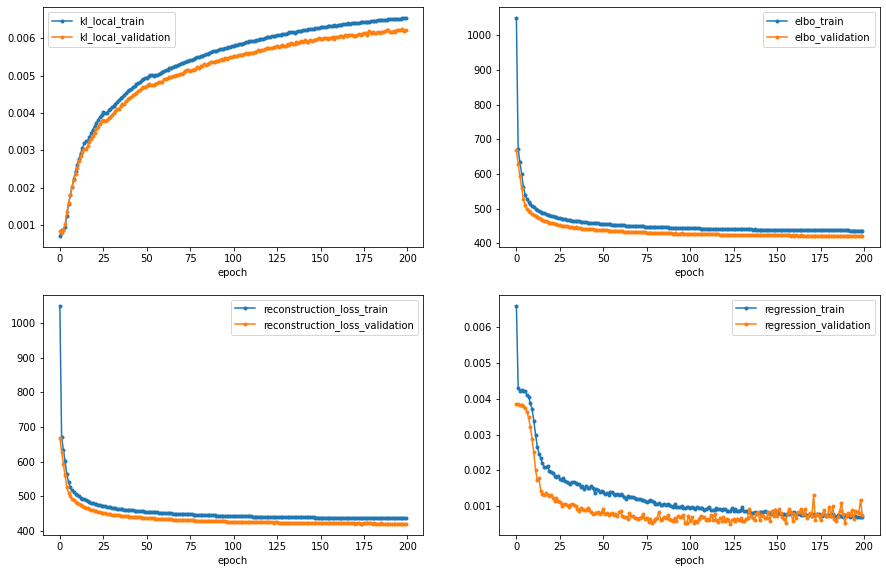

In [13]:
df = pd.DataFrame(mil.history['train_loss_step'])
for key in mil.history.keys():
    if key != 'train_loss_step':
        df = df.join(mil.history[key])

df['epoch'] = df.index

plt.figure(figsize=(15, 15))
loss_names = ['kl_local', 'elbo', 'reconstruction_loss', 'regression']
nrows = 3

for i, name in enumerate(loss_names):
    plt.subplot(nrows, 2, i+1)
    plt.plot(df['epoch'], df[name+'_train'], '.-', label=name+'_train')
    plt.plot(df['epoch'], df[name+'_validation'], '.-', label=name+'_validation')

    plt.xlabel('epoch')
    plt.legend()

# Inference

Get the latent representation.

In [14]:
mil.get_model_output(batch_size=512)
adata

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(
/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


creating df....
               0
0       3.299737
1       3.299737
2       3.299737
3       3.299737
4       3.299737
...          ...
530411  1.742539
530412  1.742539
530413  1.742539
530414  1.742539
530415  1.742539

[530416 rows x 1 columns]
['Status_on_day_collection_summary']
creating df....
        0
0     4.0
1     4.0
2     4.0
3     4.0
4     4.0
...   ...
4038  0.0
4039  0.0
4040  0.0
4041  0.0
4042  0.0

[4043 rows x 1 columns]
['Status_on_day_collection_summary']
creating df....
             0
0     3.299737
1     3.649315
2     3.335610
3     3.377120
4     3.184115
...        ...
4038  0.555569
4039  0.733662
4040  0.727934
4041  0.484426
4042  1.742539

[4043 rows x 1 columns]
['Status_on_day_collection_summary']


AnnData object with n_obs × n_vars = 530416 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi', 'bag_ordinal_true', 'bag_ordinal_predictions'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent', 'cov_attn', 'ordinal_predictions'
    layers: 'count'

Visualize results.

... storing 'feature_types' as categorical
... storing 'highly_variable' as categorical


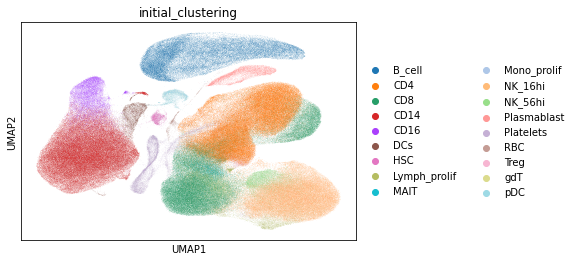

In [15]:
sc.pp.neighbors(adata, use_rep='latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color='initial_clustering')

# Query

In [16]:
mtg.model.MultiVAE_MIL.setup_query(
        adata,
        query,
        rna_indices_end=4000,  # how many features in rna modality
        categorical_covariate_keys=['Sex', 'patient_id', 'Status_on_day_collection_summary'],
        continuous_covariate_keys=['Age'],
        ordinal_regression_order={'Status_on_day_collection_summary': ["Healthy", "Asymptomatic", "Mild", "Moderate", "Severe", "Critical"]}
    )

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 40911 cells, 4192 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 2 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 40911 cells, 4192 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra c

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


In [17]:
new_model = mtg.model.MultiVAE_MIL.load_query_data(query, mil)

The order for Status_on_day_collection_summary ordinal classes is: Index(['Healthy', 'Asymptomatic', 'Mild', 'Moderate', 'Severe', 'Critical'], dtype='object'). If you need to change the order, please rerun setup_anndata and specify the correct order with "ordinal_regression_order" parameter.
INFO     Using data from adata.X                                                             
INFO     Registered keys:['X', 'batch_indices', 'labels', 'cat_covs', 'cont_covs']           
INFO     Successfully registered anndata object containing 40911 cells, 4192 vars, 1 batches,
         1 labels, and 0 proteins. Also registered 3 extra categorical covariates and 2 extra
         continuous covariates.                                                              


/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/scvi/model/base/_base_model.py:150: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.


Epoch 1/200:   0%|          | 1/200 [00:01<05:53,  1.78s/it, loss=586, v_num=1]

Metric elbo_validation improved. New best score: 563.821


Epoch 2/200:   1%|          | 2/200 [00:03<05:22,  1.63s/it, loss=587, v_num=1]

Metric elbo_validation improved by 1.556 >= min_delta = 0.0. New best score: 562.265


Epoch 3/200:   2%|▏         | 3/200 [00:04<05:16,  1.61s/it, loss=582, v_num=1]

Metric elbo_validation improved by 1.616 >= min_delta = 0.0. New best score: 560.649


Epoch 4/200:   2%|▏         | 4/200 [00:07<05:53,  1.80s/it, loss=586, v_num=1]

Metric elbo_validation improved by 1.613 >= min_delta = 0.0. New best score: 559.036


Epoch 5/200:   2%|▎         | 5/200 [00:08<05:51,  1.80s/it, loss=584, v_num=1]

Metric elbo_validation improved by 1.522 >= min_delta = 0.0. New best score: 557.514


Epoch 6/200:   3%|▎         | 6/200 [00:10<06:04,  1.88s/it, loss=574, v_num=1]

Metric elbo_validation improved by 1.649 >= min_delta = 0.0. New best score: 555.865


Epoch 7/200:   4%|▎         | 7/200 [00:12<05:37,  1.75s/it, loss=575, v_num=1]

Metric elbo_validation improved by 1.487 >= min_delta = 0.0. New best score: 554.378


Epoch 8/200:   4%|▍         | 8/200 [00:14<05:54,  1.84s/it, loss=572, v_num=1]

Metric elbo_validation improved by 1.448 >= min_delta = 0.0. New best score: 552.930


Epoch 9/200:   4%|▍         | 9/200 [00:16<06:08,  1.93s/it, loss=580, v_num=1]

Metric elbo_validation improved by 1.536 >= min_delta = 0.0. New best score: 551.394


Epoch 10/200:   5%|▌         | 10/200 [00:18<06:14,  1.97s/it, loss=587, v_num=1]

Metric elbo_validation improved by 1.577 >= min_delta = 0.0. New best score: 549.817


Epoch 11/200:   6%|▌         | 11/200 [00:20<05:53,  1.87s/it, loss=577, v_num=1]

Metric elbo_validation improved by 1.428 >= min_delta = 0.0. New best score: 548.388


Epoch 12/200:   6%|▌         | 12/200 [00:21<05:28,  1.75s/it, loss=569, v_num=1]

Metric elbo_validation improved by 1.460 >= min_delta = 0.0. New best score: 546.928


Epoch 13/200:   6%|▋         | 13/200 [00:23<05:57,  1.91s/it, loss=571, v_num=1]

Metric elbo_validation improved by 1.518 >= min_delta = 0.0. New best score: 545.410


Epoch 14/200:   7%|▋         | 14/200 [00:26<06:06,  1.97s/it, loss=570, v_num=1]

Metric elbo_validation improved by 1.405 >= min_delta = 0.0. New best score: 544.005


Epoch 15/200:   8%|▊         | 15/200 [00:28<06:09,  2.00s/it, loss=568, v_num=1]

Metric elbo_validation improved by 1.481 >= min_delta = 0.0. New best score: 542.524


Epoch 16/200:   8%|▊         | 16/200 [00:29<05:40,  1.85s/it, loss=560, v_num=1]

Metric elbo_validation improved by 1.362 >= min_delta = 0.0. New best score: 541.162


Epoch 17/200:   8%|▊         | 17/200 [00:31<05:21,  1.76s/it, loss=561, v_num=1]

Metric elbo_validation improved by 1.431 >= min_delta = 0.0. New best score: 539.731


Epoch 18/200:   9%|▉         | 18/200 [00:32<05:18,  1.75s/it, loss=560, v_num=1]

Metric elbo_validation improved by 1.388 >= min_delta = 0.0. New best score: 538.343


Epoch 19/200:  10%|▉         | 19/200 [00:34<05:24,  1.79s/it, loss=559, v_num=1]

Metric elbo_validation improved by 1.339 >= min_delta = 0.0. New best score: 537.004


Epoch 20/200:  10%|█         | 20/200 [00:36<05:32,  1.85s/it, loss=561, v_num=1]

Metric elbo_validation improved by 1.403 >= min_delta = 0.0. New best score: 535.601


Epoch 21/200:  10%|█         | 21/200 [00:38<05:29,  1.84s/it, loss=562, v_num=1]

Metric elbo_validation improved by 1.448 >= min_delta = 0.0. New best score: 534.153


Epoch 22/200:  11%|█         | 22/200 [00:40<05:38,  1.90s/it, loss=553, v_num=1]

Metric elbo_validation improved by 1.330 >= min_delta = 0.0. New best score: 532.823


Epoch 23/200:  12%|█▏        | 23/200 [00:42<05:12,  1.76s/it, loss=555, v_num=1]

Metric elbo_validation improved by 1.433 >= min_delta = 0.0. New best score: 531.390


Epoch 24/200:  12%|█▏        | 24/200 [00:43<05:02,  1.72s/it, loss=552, v_num=1]

Metric elbo_validation improved by 1.286 >= min_delta = 0.0. New best score: 530.104


Epoch 25/200:  12%|█▎        | 25/200 [00:45<05:23,  1.85s/it, loss=546, v_num=1]

Metric elbo_validation improved by 1.352 >= min_delta = 0.0. New best score: 528.752


Epoch 26/200:  13%|█▎        | 26/200 [00:47<05:10,  1.78s/it, loss=545, v_num=1]

Metric elbo_validation improved by 1.387 >= min_delta = 0.0. New best score: 527.365


Epoch 27/200:  14%|█▎        | 27/200 [00:48<04:27,  1.54s/it, loss=549, v_num=1]

Metric elbo_validation improved by 1.393 >= min_delta = 0.0. New best score: 525.972


Epoch 28/200:  14%|█▍        | 28/200 [00:49<03:58,  1.39s/it, loss=544, v_num=1]

Metric elbo_validation improved by 1.333 >= min_delta = 0.0. New best score: 524.639


Epoch 29/200:  14%|█▍        | 29/200 [00:51<04:12,  1.47s/it, loss=540, v_num=1]

Metric elbo_validation improved by 1.447 >= min_delta = 0.0. New best score: 523.192


Epoch 30/200:  15%|█▌        | 30/200 [00:53<04:28,  1.58s/it, loss=542, v_num=1]

Metric elbo_validation improved by 1.355 >= min_delta = 0.0. New best score: 521.837


Epoch 31/200:  16%|█▌        | 31/200 [00:54<04:27,  1.58s/it, loss=541, v_num=1]

Metric elbo_validation improved by 1.381 >= min_delta = 0.0. New best score: 520.456


Epoch 32/200:  16%|█▌        | 32/200 [00:56<04:27,  1.59s/it, loss=537, v_num=1]

Metric elbo_validation improved by 1.356 >= min_delta = 0.0. New best score: 519.100


Epoch 33/200:  16%|█▋        | 33/200 [00:57<04:36,  1.66s/it, loss=537, v_num=1]

Metric elbo_validation improved by 1.396 >= min_delta = 0.0. New best score: 517.704


Epoch 34/200:  17%|█▋        | 34/200 [00:59<04:24,  1.59s/it, loss=536, v_num=1]

Metric elbo_validation improved by 1.349 >= min_delta = 0.0. New best score: 516.355


Epoch 35/200:  18%|█▊        | 35/200 [01:00<04:09,  1.51s/it, loss=534, v_num=1]

Metric elbo_validation improved by 1.343 >= min_delta = 0.0. New best score: 515.012


Epoch 36/200:  18%|█▊        | 36/200 [01:02<04:19,  1.58s/it, loss=535, v_num=1]

Metric elbo_validation improved by 1.366 >= min_delta = 0.0. New best score: 513.647


Epoch 37/200:  18%|█▊        | 37/200 [01:04<04:20,  1.60s/it, loss=532, v_num=1]

Metric elbo_validation improved by 1.410 >= min_delta = 0.0. New best score: 512.237


Epoch 38/200:  19%|█▉        | 38/200 [01:05<04:07,  1.53s/it, loss=534, v_num=1]

Metric elbo_validation improved by 1.263 >= min_delta = 0.0. New best score: 510.974


Epoch 39/200:  20%|█▉        | 39/200 [01:06<04:01,  1.50s/it, loss=527, v_num=1]

Metric elbo_validation improved by 1.283 >= min_delta = 0.0. New best score: 509.691


Epoch 40/200:  20%|██        | 40/200 [01:08<04:17,  1.61s/it, loss=535, v_num=1]

Metric elbo_validation improved by 1.331 >= min_delta = 0.0. New best score: 508.360


Epoch 41/200:  20%|██        | 41/200 [01:10<04:24,  1.67s/it, loss=528, v_num=1]

Metric elbo_validation improved by 1.279 >= min_delta = 0.0. New best score: 507.081


Epoch 42/200:  21%|██        | 42/200 [01:12<04:10,  1.59s/it, loss=521, v_num=1]

Metric elbo_validation improved by 1.324 >= min_delta = 0.0. New best score: 505.758


Epoch 43/200:  22%|██▏       | 43/200 [01:13<04:06,  1.57s/it, loss=521, v_num=1]

Metric elbo_validation improved by 1.235 >= min_delta = 0.0. New best score: 504.523


Epoch 44/200:  22%|██▏       | 44/200 [01:15<04:32,  1.75s/it, loss=523, v_num=1]

Metric elbo_validation improved by 1.269 >= min_delta = 0.0. New best score: 503.254


Epoch 45/200:  22%|██▎       | 45/200 [01:17<04:45,  1.84s/it, loss=520, v_num=1]

Metric elbo_validation improved by 1.249 >= min_delta = 0.0. New best score: 502.005


Epoch 46/200:  23%|██▎       | 46/200 [01:20<05:03,  1.97s/it, loss=522, v_num=1]

Metric elbo_validation improved by 1.281 >= min_delta = 0.0. New best score: 500.724


Epoch 47/200:  24%|██▎       | 47/200 [01:21<04:27,  1.75s/it, loss=514, v_num=1]

Metric elbo_validation improved by 1.260 >= min_delta = 0.0. New best score: 499.464


Epoch 48/200:  24%|██▍       | 48/200 [01:23<04:33,  1.80s/it, loss=516, v_num=1]

Metric elbo_validation improved by 1.243 >= min_delta = 0.0. New best score: 498.221


Epoch 49/200:  24%|██▍       | 49/200 [01:24<04:28,  1.78s/it, loss=518, v_num=1]

Metric elbo_validation improved by 1.201 >= min_delta = 0.0. New best score: 497.020


Epoch 50/200:  25%|██▌       | 50/200 [01:26<04:32,  1.81s/it, loss=516, v_num=1]

Metric elbo_validation improved by 1.190 >= min_delta = 0.0. New best score: 495.830


Epoch 51/200:  26%|██▌       | 51/200 [01:28<04:17,  1.73s/it, loss=511, v_num=1]

Metric elbo_validation improved by 1.161 >= min_delta = 0.0. New best score: 494.668


Epoch 52/200:  26%|██▌       | 52/200 [01:30<04:11,  1.70s/it, loss=512, v_num=1]

Metric elbo_validation improved by 1.194 >= min_delta = 0.0. New best score: 493.474


Epoch 53/200:  26%|██▋       | 53/200 [01:31<04:21,  1.78s/it, loss=512, v_num=1]

Metric elbo_validation improved by 1.175 >= min_delta = 0.0. New best score: 492.299


Epoch 54/200:  27%|██▋       | 54/200 [01:34<04:33,  1.87s/it, loss=511, v_num=1]

Metric elbo_validation improved by 1.128 >= min_delta = 0.0. New best score: 491.171


Epoch 55/200:  28%|██▊       | 55/200 [01:35<04:21,  1.80s/it, loss=510, v_num=1]

Metric elbo_validation improved by 1.137 >= min_delta = 0.0. New best score: 490.034


Epoch 56/200:  28%|██▊       | 56/200 [01:37<04:38,  1.94s/it, loss=510, v_num=1]

Metric elbo_validation improved by 1.067 >= min_delta = 0.0. New best score: 488.967


Epoch 57/200:  28%|██▊       | 57/200 [01:39<04:15,  1.78s/it, loss=504, v_num=1]

Metric elbo_validation improved by 1.135 >= min_delta = 0.0. New best score: 487.832


Epoch 58/200:  29%|██▉       | 58/200 [01:41<04:09,  1.76s/it, loss=508, v_num=1]

Metric elbo_validation improved by 1.057 >= min_delta = 0.0. New best score: 486.775


Epoch 59/200:  30%|██▉       | 59/200 [01:42<04:16,  1.82s/it, loss=509, v_num=1]

Metric elbo_validation improved by 1.050 >= min_delta = 0.0. New best score: 485.724


Epoch 60/200:  30%|███       | 60/200 [01:44<04:12,  1.80s/it, loss=502, v_num=1]

Metric elbo_validation improved by 1.030 >= min_delta = 0.0. New best score: 484.694


Epoch 61/200:  30%|███       | 61/200 [01:46<04:07,  1.78s/it, loss=506, v_num=1]

Metric elbo_validation improved by 0.957 >= min_delta = 0.0. New best score: 483.737


Epoch 62/200:  31%|███       | 62/200 [01:48<04:11,  1.82s/it, loss=500, v_num=1]

Metric elbo_validation improved by 0.999 >= min_delta = 0.0. New best score: 482.739


Epoch 63/200:  32%|███▏      | 63/200 [01:49<03:55,  1.72s/it, loss=501, v_num=1]

Metric elbo_validation improved by 0.922 >= min_delta = 0.0. New best score: 481.817


Epoch 64/200:  32%|███▏      | 64/200 [01:52<04:10,  1.84s/it, loss=499, v_num=1]

Metric elbo_validation improved by 0.962 >= min_delta = 0.0. New best score: 480.855


Epoch 65/200:  32%|███▎      | 65/200 [01:53<04:04,  1.81s/it, loss=499, v_num=1]

Metric elbo_validation improved by 0.933 >= min_delta = 0.0. New best score: 479.921


Epoch 66/200:  33%|███▎      | 66/200 [01:55<04:11,  1.88s/it, loss=498, v_num=1]

Metric elbo_validation improved by 0.874 >= min_delta = 0.0. New best score: 479.048


Epoch 67/200:  34%|███▎      | 67/200 [01:57<04:01,  1.81s/it, loss=499, v_num=1]

Metric elbo_validation improved by 0.888 >= min_delta = 0.0. New best score: 478.160


Epoch 68/200:  34%|███▍      | 68/200 [01:59<04:08,  1.89s/it, loss=497, v_num=1]

Metric elbo_validation improved by 0.908 >= min_delta = 0.0. New best score: 477.251


Epoch 69/200:  34%|███▍      | 69/200 [02:00<03:44,  1.71s/it, loss=493, v_num=1]

Metric elbo_validation improved by 0.832 >= min_delta = 0.0. New best score: 476.420


Epoch 70/200:  35%|███▌      | 70/200 [02:02<03:36,  1.66s/it, loss=493, v_num=1]

Metric elbo_validation improved by 0.851 >= min_delta = 0.0. New best score: 475.569


Epoch 71/200:  36%|███▌      | 71/200 [02:04<03:52,  1.80s/it, loss=492, v_num=1]

Metric elbo_validation improved by 0.784 >= min_delta = 0.0. New best score: 474.784


Epoch 72/200:  36%|███▌      | 72/200 [02:06<03:55,  1.84s/it, loss=491, v_num=1]

Metric elbo_validation improved by 0.789 >= min_delta = 0.0. New best score: 473.995


Epoch 73/200:  36%|███▋      | 73/200 [02:08<03:53,  1.84s/it, loss=492, v_num=1]

Metric elbo_validation improved by 0.814 >= min_delta = 0.0. New best score: 473.181


Epoch 74/200:  37%|███▋      | 74/200 [02:09<03:33,  1.70s/it, loss=490, v_num=1]

Metric elbo_validation improved by 0.768 >= min_delta = 0.0. New best score: 472.413


Epoch 75/200:  38%|███▊      | 75/200 [02:11<03:27,  1.66s/it, loss=487, v_num=1]

Metric elbo_validation improved by 0.761 >= min_delta = 0.0. New best score: 471.652


Epoch 76/200:  38%|███▊      | 76/200 [02:12<03:30,  1.70s/it, loss=488, v_num=1]

Metric elbo_validation improved by 0.701 >= min_delta = 0.0. New best score: 470.951


Epoch 77/200:  38%|███▊      | 77/200 [02:14<03:25,  1.67s/it, loss=491, v_num=1]

Metric elbo_validation improved by 0.709 >= min_delta = 0.0. New best score: 470.242


Epoch 78/200:  39%|███▉      | 78/200 [02:16<03:36,  1.77s/it, loss=489, v_num=1]

Metric elbo_validation improved by 0.725 >= min_delta = 0.0. New best score: 469.517


Epoch 79/200:  40%|███▉      | 79/200 [02:18<03:23,  1.68s/it, loss=489, v_num=1]

Metric elbo_validation improved by 0.669 >= min_delta = 0.0. New best score: 468.848


Epoch 80/200:  40%|████      | 80/200 [02:19<03:12,  1.60s/it, loss=484, v_num=1]

Metric elbo_validation improved by 0.675 >= min_delta = 0.0. New best score: 468.173


Epoch 81/200:  40%|████      | 81/200 [02:21<03:25,  1.73s/it, loss=485, v_num=1]

Metric elbo_validation improved by 0.654 >= min_delta = 0.0. New best score: 467.519


Epoch 82/200:  41%|████      | 82/200 [02:23<03:28,  1.76s/it, loss=487, v_num=1]

Metric elbo_validation improved by 0.630 >= min_delta = 0.0. New best score: 466.889


Epoch 83/200:  42%|████▏     | 83/200 [02:24<03:19,  1.71s/it, loss=485, v_num=1]

Metric elbo_validation improved by 0.630 >= min_delta = 0.0. New best score: 466.260


Epoch 84/200:  42%|████▏     | 84/200 [02:26<03:15,  1.69s/it, loss=483, v_num=1]

Metric elbo_validation improved by 0.643 >= min_delta = 0.0. New best score: 465.617


Epoch 85/200:  42%|████▎     | 85/200 [02:28<03:19,  1.73s/it, loss=481, v_num=1]

Metric elbo_validation improved by 0.561 >= min_delta = 0.0. New best score: 465.056


Epoch 86/200:  43%|████▎     | 86/200 [02:30<03:19,  1.75s/it, loss=482, v_num=1]

Metric elbo_validation improved by 0.580 >= min_delta = 0.0. New best score: 464.476


Epoch 87/200:  44%|████▎     | 87/200 [02:31<03:06,  1.65s/it, loss=482, v_num=1]

Metric elbo_validation improved by 0.580 >= min_delta = 0.0. New best score: 463.896


Epoch 88/200:  44%|████▍     | 88/200 [02:32<02:55,  1.56s/it, loss=480, v_num=1]

Metric elbo_validation improved by 0.547 >= min_delta = 0.0. New best score: 463.349


Epoch 89/200:  44%|████▍     | 89/200 [02:34<02:56,  1.59s/it, loss=482, v_num=1]

Metric elbo_validation improved by 0.554 >= min_delta = 0.0. New best score: 462.795


Epoch 90/200:  45%|████▌     | 90/200 [02:36<02:57,  1.61s/it, loss=480, v_num=1]

Metric elbo_validation improved by 0.526 >= min_delta = 0.0. New best score: 462.269


Epoch 91/200:  46%|████▌     | 91/200 [02:37<02:48,  1.55s/it, loss=478, v_num=1]

Metric elbo_validation improved by 0.517 >= min_delta = 0.0. New best score: 461.752


Epoch 92/200:  46%|████▌     | 92/200 [02:39<02:43,  1.51s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.549 >= min_delta = 0.0. New best score: 461.204


Epoch 93/200:  46%|████▋     | 93/200 [02:40<02:46,  1.56s/it, loss=478, v_num=1]

Metric elbo_validation improved by 0.483 >= min_delta = 0.0. New best score: 460.721


Epoch 94/200:  47%|████▋     | 94/200 [02:42<02:47,  1.58s/it, loss=476, v_num=1]

Metric elbo_validation improved by 0.515 >= min_delta = 0.0. New best score: 460.206


Epoch 95/200:  48%|████▊     | 95/200 [02:43<02:45,  1.57s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.477 >= min_delta = 0.0. New best score: 459.729


Epoch 96/200:  48%|████▊     | 96/200 [02:45<02:48,  1.62s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.472 >= min_delta = 0.0. New best score: 459.256


Epoch 97/200:  48%|████▊     | 97/200 [02:47<02:54,  1.69s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.457 >= min_delta = 0.0. New best score: 458.799


Epoch 98/200:  49%|████▉     | 98/200 [02:49<03:02,  1.79s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.465 >= min_delta = 0.0. New best score: 458.335


Epoch 99/200:  50%|████▉     | 99/200 [02:51<03:06,  1.85s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.440 >= min_delta = 0.0. New best score: 457.894


Epoch 100/200:  50%|█████     | 100/200 [02:53<02:58,  1.78s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.439 >= min_delta = 0.0. New best score: 457.455


Epoch 101/200:  50%|█████     | 101/200 [02:54<02:45,  1.67s/it, loss=474, v_num=1]

Metric elbo_validation improved by 0.439 >= min_delta = 0.0. New best score: 457.016


Epoch 102/200:  51%|█████     | 102/200 [02:56<02:44,  1.68s/it, loss=475, v_num=1]

Metric elbo_validation improved by 0.410 >= min_delta = 0.0. New best score: 456.606


Epoch 103/200:  52%|█████▏    | 103/200 [02:57<02:43,  1.69s/it, loss=471, v_num=1]

Metric elbo_validation improved by 0.405 >= min_delta = 0.0. New best score: 456.201


Epoch 104/200:  52%|█████▏    | 104/200 [02:59<02:43,  1.70s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.419 >= min_delta = 0.0. New best score: 455.782


Epoch 105/200:  52%|█████▎    | 105/200 [03:01<02:29,  1.57s/it, loss=477, v_num=1]

Metric elbo_validation improved by 0.403 >= min_delta = 0.0. New best score: 455.379


Epoch 106/200:  53%|█████▎    | 106/200 [03:02<02:34,  1.64s/it, loss=472, v_num=1]

Metric elbo_validation improved by 0.383 >= min_delta = 0.0. New best score: 454.996


Epoch 107/200:  54%|█████▎    | 107/200 [03:04<02:39,  1.72s/it, loss=476, v_num=1]

Metric elbo_validation improved by 0.375 >= min_delta = 0.0. New best score: 454.621


Epoch 108/200:  54%|█████▍    | 108/200 [03:06<02:45,  1.80s/it, loss=470, v_num=1]

Metric elbo_validation improved by 0.408 >= min_delta = 0.0. New best score: 454.214


Epoch 109/200:  55%|█████▍    | 109/200 [03:08<02:40,  1.76s/it, loss=470, v_num=1]

Metric elbo_validation improved by 0.348 >= min_delta = 0.0. New best score: 453.866


Epoch 110/200:  55%|█████▌    | 110/200 [03:10<02:34,  1.72s/it, loss=470, v_num=1]

Metric elbo_validation improved by 0.368 >= min_delta = 0.0. New best score: 453.497


Epoch 111/200:  56%|█████▌    | 111/200 [03:11<02:30,  1.70s/it, loss=468, v_num=1]

Metric elbo_validation improved by 0.352 >= min_delta = 0.0. New best score: 453.145


Epoch 112/200:  56%|█████▌    | 112/200 [03:13<02:33,  1.75s/it, loss=470, v_num=1]

Metric elbo_validation improved by 0.354 >= min_delta = 0.0. New best score: 452.791


Epoch 113/200:  56%|█████▋    | 113/200 [03:15<02:28,  1.71s/it, loss=469, v_num=1]

Metric elbo_validation improved by 0.348 >= min_delta = 0.0. New best score: 452.444


Epoch 114/200:  57%|█████▋    | 114/200 [03:16<02:15,  1.57s/it, loss=471, v_num=1]

Metric elbo_validation improved by 0.373 >= min_delta = 0.0. New best score: 452.071


Epoch 115/200:  57%|█████▊    | 115/200 [03:18<02:25,  1.72s/it, loss=469, v_num=1]

Metric elbo_validation improved by 0.341 >= min_delta = 0.0. New best score: 451.730


Epoch 116/200:  58%|█████▊    | 116/200 [03:20<02:22,  1.70s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.351 >= min_delta = 0.0. New best score: 451.380


Epoch 117/200:  58%|█████▊    | 117/200 [03:21<02:17,  1.66s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.349 >= min_delta = 0.0. New best score: 451.031


Epoch 118/200:  59%|█████▉    | 118/200 [03:23<02:11,  1.61s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.346 >= min_delta = 0.0. New best score: 450.684


Epoch 119/200:  60%|█████▉    | 119/200 [03:24<02:07,  1.57s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.322 >= min_delta = 0.0. New best score: 450.363


Epoch 120/200:  60%|██████    | 120/200 [03:26<02:11,  1.65s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.334 >= min_delta = 0.0. New best score: 450.029


Epoch 121/200:  60%|██████    | 121/200 [03:28<02:18,  1.76s/it, loss=469, v_num=1]

Metric elbo_validation improved by 0.354 >= min_delta = 0.0. New best score: 449.675


Epoch 122/200:  61%|██████    | 122/200 [03:30<02:15,  1.74s/it, loss=465, v_num=1]

Metric elbo_validation improved by 0.323 >= min_delta = 0.0. New best score: 449.352


Epoch 123/200:  62%|██████▏   | 123/200 [03:31<02:08,  1.66s/it, loss=468, v_num=1]

Metric elbo_validation improved by 0.314 >= min_delta = 0.0. New best score: 449.038


Epoch 124/200:  62%|██████▏   | 124/200 [03:33<02:12,  1.75s/it, loss=466, v_num=1]

Metric elbo_validation improved by 0.344 >= min_delta = 0.0. New best score: 448.694


Epoch 125/200:  62%|██████▎   | 125/200 [03:35<02:15,  1.81s/it, loss=466, v_num=1]

Metric elbo_validation improved by 0.299 >= min_delta = 0.0. New best score: 448.395


Epoch 126/200:  63%|██████▎   | 126/200 [03:37<02:13,  1.80s/it, loss=466, v_num=1]

Metric elbo_validation improved by 0.306 >= min_delta = 0.0. New best score: 448.089


Epoch 127/200:  64%|██████▎   | 127/200 [03:38<02:06,  1.73s/it, loss=466, v_num=1]

Metric elbo_validation improved by 0.288 >= min_delta = 0.0. New best score: 447.801


Epoch 128/200:  64%|██████▍   | 128/200 [03:40<01:58,  1.65s/it, loss=464, v_num=1]

Metric elbo_validation improved by 0.310 >= min_delta = 0.0. New best score: 447.491


Epoch 129/200:  64%|██████▍   | 129/200 [03:41<01:56,  1.64s/it, loss=467, v_num=1]

Metric elbo_validation improved by 0.280 >= min_delta = 0.0. New best score: 447.211


Epoch 130/200:  65%|██████▌   | 130/200 [03:43<02:01,  1.73s/it, loss=464, v_num=1]

Metric elbo_validation improved by 0.269 >= min_delta = 0.0. New best score: 446.943


Epoch 131/200:  66%|██████▌   | 131/200 [03:45<01:53,  1.65s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.294 >= min_delta = 0.0. New best score: 446.648


Epoch 132/200:  66%|██████▌   | 132/200 [03:46<01:45,  1.55s/it, loss=465, v_num=1]

Metric elbo_validation improved by 0.261 >= min_delta = 0.0. New best score: 446.388


Epoch 133/200:  66%|██████▋   | 133/200 [03:48<01:51,  1.66s/it, loss=466, v_num=1]

Metric elbo_validation improved by 0.302 >= min_delta = 0.0. New best score: 446.086


Epoch 134/200:  67%|██████▋   | 134/200 [03:50<01:56,  1.76s/it, loss=461, v_num=1]

Metric elbo_validation improved by 0.266 >= min_delta = 0.0. New best score: 445.820


Epoch 135/200:  68%|██████▊   | 135/200 [03:52<01:51,  1.71s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.252 >= min_delta = 0.0. New best score: 445.568


Epoch 136/200:  68%|██████▊   | 136/200 [03:53<01:48,  1.69s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.258 >= min_delta = 0.0. New best score: 445.310


Epoch 137/200:  68%|██████▊   | 137/200 [03:55<01:42,  1.62s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.254 >= min_delta = 0.0. New best score: 445.056


Epoch 138/200:  69%|██████▉   | 138/200 [03:57<01:44,  1.69s/it, loss=463, v_num=1]

Metric elbo_validation improved by 0.246 >= min_delta = 0.0. New best score: 444.810


Epoch 139/200:  70%|██████▉   | 139/200 [03:59<01:45,  1.73s/it, loss=465, v_num=1]

Metric elbo_validation improved by 0.263 >= min_delta = 0.0. New best score: 444.548


Epoch 140/200:  70%|███████   | 140/200 [04:00<01:38,  1.64s/it, loss=463, v_num=1]

Metric elbo_validation improved by 0.240 >= min_delta = 0.0. New best score: 444.307


Epoch 141/200:  70%|███████   | 141/200 [04:01<01:32,  1.56s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.265 >= min_delta = 0.0. New best score: 444.042


Epoch 142/200:  71%|███████   | 142/200 [04:03<01:36,  1.66s/it, loss=464, v_num=1]

Metric elbo_validation improved by 0.225 >= min_delta = 0.0. New best score: 443.817


Epoch 143/200:  72%|███████▏  | 143/200 [04:05<01:33,  1.64s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.252 >= min_delta = 0.0. New best score: 443.565


Epoch 144/200:  72%|███████▏  | 144/200 [04:06<01:26,  1.55s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.206 >= min_delta = 0.0. New best score: 443.359


Epoch 145/200:  72%|███████▎  | 145/200 [04:08<01:25,  1.55s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.244 >= min_delta = 0.0. New best score: 443.115


Epoch 146/200:  73%|███████▎  | 146/200 [04:09<01:26,  1.59s/it, loss=465, v_num=1]

Metric elbo_validation improved by 0.204 >= min_delta = 0.0. New best score: 442.911


Epoch 147/200:  74%|███████▎  | 147/200 [04:11<01:26,  1.63s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.202 >= min_delta = 0.0. New best score: 442.708


Epoch 148/200:  74%|███████▍  | 148/200 [04:13<01:22,  1.58s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.204 >= min_delta = 0.0. New best score: 442.505


Epoch 149/200:  74%|███████▍  | 149/200 [04:14<01:21,  1.60s/it, loss=462, v_num=1]

Metric elbo_validation improved by 0.216 >= min_delta = 0.0. New best score: 442.289


Epoch 150/200:  75%|███████▌  | 150/200 [04:16<01:24,  1.68s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.172 >= min_delta = 0.0. New best score: 442.117


Epoch 151/200:  76%|███████▌  | 151/200 [04:18<01:22,  1.68s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.200 >= min_delta = 0.0. New best score: 441.917


Epoch 152/200:  76%|███████▌  | 152/200 [04:19<01:14,  1.56s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.171 >= min_delta = 0.0. New best score: 441.746


Epoch 153/200:  76%|███████▋  | 153/200 [04:20<01:10,  1.49s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.162 >= min_delta = 0.0. New best score: 441.583


Epoch 154/200:  77%|███████▋  | 154/200 [04:22<01:12,  1.57s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.194 >= min_delta = 0.0. New best score: 441.390


Epoch 155/200:  78%|███████▊  | 155/200 [04:24<01:14,  1.66s/it, loss=461, v_num=1]

Metric elbo_validation improved by 0.183 >= min_delta = 0.0. New best score: 441.207


Epoch 156/200:  78%|███████▊  | 156/200 [04:25<01:09,  1.58s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.155 >= min_delta = 0.0. New best score: 441.052


Epoch 157/200:  78%|███████▊  | 157/200 [04:27<01:07,  1.57s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.140 >= min_delta = 0.0. New best score: 440.912


Epoch 158/200:  79%|███████▉  | 158/200 [04:29<01:06,  1.59s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.151 >= min_delta = 0.0. New best score: 440.761


Epoch 159/200:  80%|███████▉  | 159/200 [04:31<01:10,  1.71s/it, loss=460, v_num=1]

Metric elbo_validation improved by 0.122 >= min_delta = 0.0. New best score: 440.638


Epoch 160/200:  80%|████████  | 160/200 [04:32<01:11,  1.79s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.184 >= min_delta = 0.0. New best score: 440.454


Epoch 161/200:  80%|████████  | 161/200 [04:34<01:08,  1.76s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.142 >= min_delta = 0.0. New best score: 440.312


Epoch 162/200:  81%|████████  | 162/200 [04:36<01:01,  1.63s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.123 >= min_delta = 0.0. New best score: 440.189


Epoch 163/200:  82%|████████▏ | 163/200 [04:37<01:03,  1.71s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.132 >= min_delta = 0.0. New best score: 440.057


Epoch 164/200:  82%|████████▏ | 164/200 [04:39<01:03,  1.77s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.130 >= min_delta = 0.0. New best score: 439.927


Epoch 165/200:  82%|████████▎ | 165/200 [04:41<00:57,  1.63s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.106 >= min_delta = 0.0. New best score: 439.821


Epoch 166/200:  83%|████████▎ | 166/200 [04:42<00:54,  1.61s/it, loss=458, v_num=1]

Metric elbo_validation improved by 0.120 >= min_delta = 0.0. New best score: 439.701


Epoch 167/200:  84%|████████▎ | 167/200 [04:44<00:54,  1.66s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.144 >= min_delta = 0.0. New best score: 439.557


Epoch 168/200:  84%|████████▍ | 168/200 [04:46<00:53,  1.68s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.080 >= min_delta = 0.0. New best score: 439.477


Epoch 169/200:  84%|████████▍ | 169/200 [04:47<00:49,  1.59s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.113 >= min_delta = 0.0. New best score: 439.364


Epoch 170/200:  85%|████████▌ | 170/200 [04:49<00:48,  1.62s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.112 >= min_delta = 0.0. New best score: 439.251


Epoch 171/200:  86%|████████▌ | 171/200 [04:51<00:50,  1.75s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.112 >= min_delta = 0.0. New best score: 439.139


Epoch 172/200:  86%|████████▌ | 172/200 [04:53<00:51,  1.83s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.102 >= min_delta = 0.0. New best score: 439.037


Epoch 173/200:  86%|████████▋ | 173/200 [04:55<00:53,  1.98s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.089 >= min_delta = 0.0. New best score: 438.948


Epoch 174/200:  87%|████████▋ | 174/200 [04:57<00:50,  1.94s/it, loss=459, v_num=1]

Metric elbo_validation improved by 0.077 >= min_delta = 0.0. New best score: 438.871


Epoch 175/200:  88%|████████▊ | 175/200 [04:59<00:47,  1.90s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.084 >= min_delta = 0.0. New best score: 438.787


Epoch 176/200:  88%|████████▊ | 176/200 [05:00<00:42,  1.78s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.091 >= min_delta = 0.0. New best score: 438.696


Epoch 177/200:  88%|████████▊ | 177/200 [05:02<00:41,  1.79s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.085 >= min_delta = 0.0. New best score: 438.610


Epoch 178/200:  89%|████████▉ | 178/200 [05:04<00:40,  1.82s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 438.524


Epoch 179/200:  90%|████████▉ | 179/200 [05:06<00:40,  1.91s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.095 >= min_delta = 0.0. New best score: 438.429


Epoch 180/200:  90%|█████████ | 180/200 [05:08<00:37,  1.88s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.066 >= min_delta = 0.0. New best score: 438.364


Epoch 181/200:  90%|█████████ | 181/200 [05:10<00:34,  1.82s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 438.276


Epoch 182/200:  91%|█████████ | 182/200 [05:11<00:31,  1.73s/it, loss=456, v_num=1]

Metric elbo_validation improved by 0.060 >= min_delta = 0.0. New best score: 438.217


Epoch 183/200:  92%|█████████▏| 183/200 [05:13<00:29,  1.75s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.065 >= min_delta = 0.0. New best score: 438.152


Epoch 184/200:  92%|█████████▏| 184/200 [05:15<00:28,  1.78s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.087 >= min_delta = 0.0. New best score: 438.065


Epoch 185/200:  92%|█████████▎| 185/200 [05:16<00:24,  1.62s/it, loss=453, v_num=1]

Metric elbo_validation improved by 0.066 >= min_delta = 0.0. New best score: 437.999


Epoch 186/200:  93%|█████████▎| 186/200 [05:18<00:22,  1.58s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.066 >= min_delta = 0.0. New best score: 437.932


Epoch 187/200:  94%|█████████▎| 187/200 [05:19<00:20,  1.59s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.085 >= min_delta = 0.0. New best score: 437.847


Epoch 188/200:  94%|█████████▍| 188/200 [05:21<00:20,  1.70s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.060 >= min_delta = 0.0. New best score: 437.787


Epoch 189/200:  94%|█████████▍| 189/200 [05:23<00:18,  1.70s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.072 >= min_delta = 0.0. New best score: 437.714


Epoch 190/200:  95%|█████████▌| 190/200 [05:24<00:16,  1.65s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.069 >= min_delta = 0.0. New best score: 437.646


Epoch 191/200:  96%|█████████▌| 191/200 [05:26<00:15,  1.68s/it, loss=455, v_num=1]

Metric elbo_validation improved by 0.035 >= min_delta = 0.0. New best score: 437.611


Epoch 192/200:  96%|█████████▌| 192/200 [05:28<00:13,  1.73s/it, loss=451, v_num=1]

Metric elbo_validation improved by 0.080 >= min_delta = 0.0. New best score: 437.531


Epoch 193/200:  96%|█████████▋| 193/200 [05:30<00:12,  1.72s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.075 >= min_delta = 0.0. New best score: 437.456


Epoch 194/200:  97%|█████████▋| 194/200 [05:31<00:10,  1.68s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.035 >= min_delta = 0.0. New best score: 437.421


Epoch 195/200:  98%|█████████▊| 195/200 [05:33<00:08,  1.64s/it, loss=451, v_num=1]

Metric elbo_validation improved by 0.076 >= min_delta = 0.0. New best score: 437.345


Epoch 196/200:  98%|█████████▊| 196/200 [05:34<00:06,  1.62s/it, loss=453, v_num=1]

Metric elbo_validation improved by 0.039 >= min_delta = 0.0. New best score: 437.306


Epoch 197/200:  98%|█████████▊| 197/200 [05:36<00:04,  1.64s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.062 >= min_delta = 0.0. New best score: 437.244


Epoch 198/200:  99%|█████████▉| 198/200 [05:38<00:03,  1.70s/it, loss=457, v_num=1]

Metric elbo_validation improved by 0.065 >= min_delta = 0.0. New best score: 437.178


Epoch 199/200: 100%|█████████▉| 199/200 [05:40<00:01,  1.69s/it, loss=452, v_num=1]

Metric elbo_validation improved by 0.046 >= min_delta = 0.0. New best score: 437.133


Epoch 200/200: 100%|██████████| 200/200 [05:41<00:00,  1.62s/it, loss=454, v_num=1]

Metric elbo_validation improved by 0.058 >= min_delta = 0.0. New best score: 437.075


Epoch 200/200: 100%|██████████| 200/200 [05:41<00:00,  1.71s/it, loss=454, v_num=1]


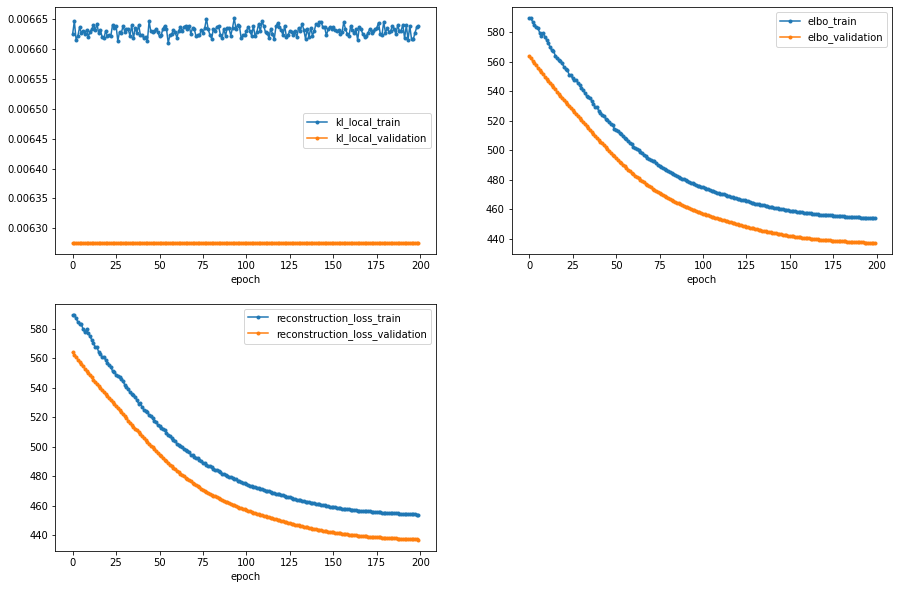

In [18]:
new_model.finetune_query(max_epochs=200, batch_size=512)

In [19]:
new_model.get_model_output(batch_size=512)
query

/home/icb/anastasia.litinetskaya/miniconda3/envs/multi/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


creating df....
              0
0      2.171004
1      2.171004
2      2.171004
3      2.171004
4      2.171004
...         ...
40906  3.757799
40907  3.757799
40908  3.757799
40909  3.757799
40910  3.757799

[40911 rows x 1 columns]
['Status_on_day_collection_summary']
creating df....
       0
0    3.0
1    3.0
2    3.0
3    3.0
4    3.0
..   ...
305  4.0
306  4.0
307  4.0
308  4.0
309  4.0

[310 rows x 1 columns]
['Status_on_day_collection_summary']
creating df....
            0
0    2.171004
1    2.306746
2    1.912736
3    2.234781
4    2.682650
..        ...
305  3.259467
306  3.736712
307  3.620547
308  3.348535
309  3.757799

[310 rows x 1 columns]
['Status_on_day_collection_summary']


AnnData object with n_obs × n_vars = 40911 × 4192
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Age', 'split', 'batch', 'split0', 'split1', 'split2', 'split3', 'split4', 'group', 'size_factors', '_scvi_batch', '_scvi_labels', 'cell_attn'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: '_scvi', 'bag_ordinal_true', 'bag_ordinal_predictions'
    obsm: '_scvi_extra_categoricals', '_scvi_extra_continuous', 'latent', 'cov_attn', 'ordinal_predictions'
    layers: 'count'

... storing 'feature_types' as categorical
... storing 'highly_variable' as categorical


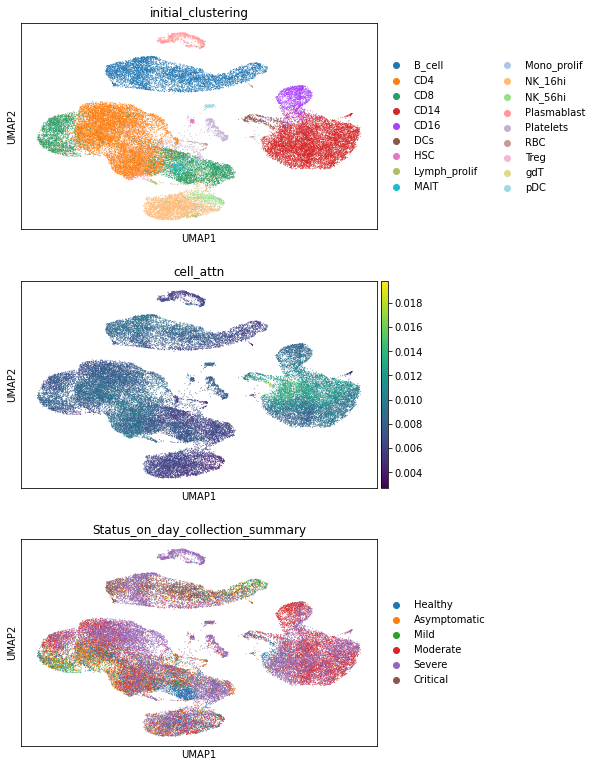

In [20]:
sc.pp.neighbors(query, use_rep='latent')
sc.tl.umap(query)
sc.pl.umap(query, color=['initial_clustering', 'cell_attn', 'Status_on_day_collection_summary'], ncols=1)

In [21]:
adata_new = sc.AnnData(query.obsm['latent'])
adata_new.obs = query.obs[['initial_clustering', 'Status_on_day_collection_summary', 'cell_attn']]
adata_new

AnnData object with n_obs × n_vars = 40911 × 15
    obs: 'initial_clustering', 'Status_on_day_collection_summary', 'cell_attn'

In [22]:
adata_old = sc.AnnData(adata.obsm['latent'])
adata_old.obs = adata.obs[['initial_clustering', 'Status_on_day_collection_summary', 'cell_attn']]
adata_old

AnnData object with n_obs × n_vars = 530416 × 15
    obs: 'initial_clustering', 'Status_on_day_collection_summary', 'cell_attn'

In [23]:
adata_both = adata_old.concatenate(adata_new)
adata_both

AnnData object with n_obs × n_vars = 571327 × 15
    obs: 'initial_clustering', 'Status_on_day_collection_summary', 'cell_attn', 'batch'

In [24]:
sc.pp.neighbors(adata_both)
sc.tl.umap(adata_both)

In [25]:
adata_both

AnnData object with n_obs × n_vars = 571327 × 15
    obs: 'initial_clustering', 'Status_on_day_collection_summary', 'cell_attn', 'batch'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

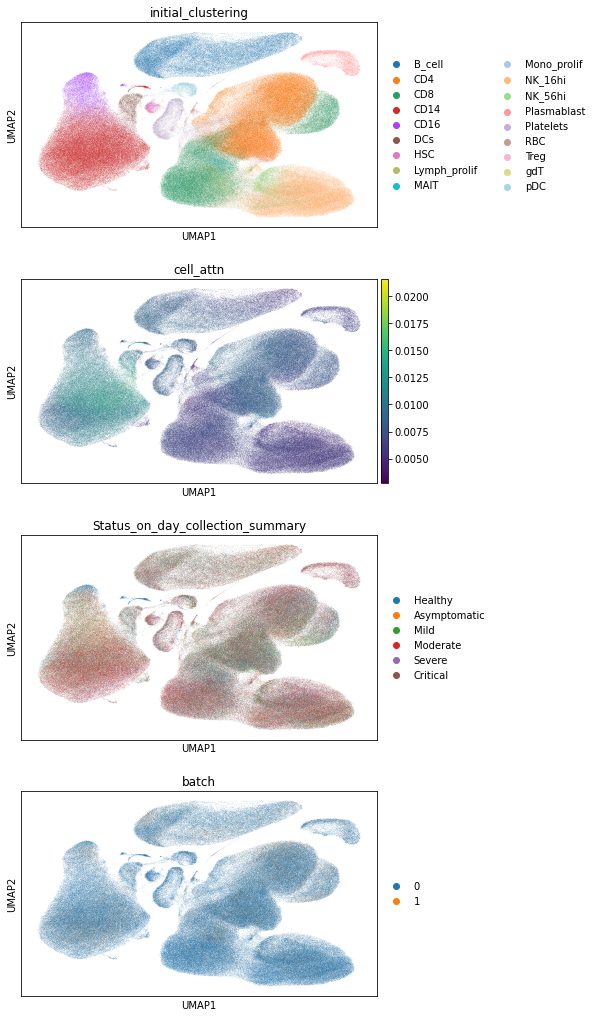

In [26]:
sc.pl.umap(adata_both, color=['initial_clustering', 'cell_attn', 'Status_on_day_collection_summary', 'batch'], ncols=1)

In [27]:
query.uns['bag_ordinal_predictions']

,Status_on_day_collection_summary
0,2.171004
1,2.306746
2,1.912736
3,2.234781
4,2.682650
...,...
305,3.259467
306,3.736712
307,3.620547
308,3.348535
